In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import ast

from geopy.distance import geodesic

from PIL import Image
from io import BytesIO

In [2]:
with open('../data/api_keys.json', 'r') as file:
    keys = json.load(file)

maps_api_key = keys['Google']
geonames_username = keys['Geonames']

# API Queries

In [3]:
coords = (40.760113, -73.87768)
url = f"http://api.geonames.org/findNearestIntersectionJSON?lat={coords[0]}&lng={coords[1]}&username={geonames_username}"
response = requests.get(url)
response.status_code
response.json()

{'credits': '1.0',
 'intersection': {'mtfcc1': 'S1400',
  'mtfcc2': 'S1400',
  'adminCode1': 'NY',
  'lng': '-73.877668',
  'distance': '0',
  'bearing': '83',
  'placename': 'New York',
  'street1Bearing': '81',
  'street2Bearing': '172',
  'adminName2': 'Queens',
  'postalcode': '11369',
  'countryCode': 'US',
  'street1': '31st Ave',
  'street2': '91st St',
  'adminName1': 'New York',
  'lat': '40.760114'}}

In [4]:
coords = (40.68535233392957, -73.99143437311176)
url = f"https://roads.googleapis.com/v1/nearestRoads?points={coords[0]},{coords[1]}&key={maps_api_key}"
nearby_response = requests.get(url)
nearby_response.status_code
print(nearby_response.json())

for i in range(len(nearby_response.json()['snappedPoints'])):
    id = nearby_response.json()['snappedPoints'][i]['placeId']
    url = f"https://maps.googleapis.com/maps/api/geocode/json?place_id={id}&key={maps_api_key}"
    response = requests.get(url)
    response.status_code
    print(response.json())

{'snappedPoints': [{'location': {'latitude': 40.68534321944763, 'longitude': -73.99141075224523}, 'originalIndex': 0, 'placeId': 'ChIJvyu4rVFawokRP5tdYIO-iTs'}]}
{'results': [{'address_components': [{'long_name': '195-189', 'short_name': '195-189', 'types': ['street_number']}, {'long_name': 'Smith Street', 'short_name': 'Smith St', 'types': ['route']}, {'long_name': 'Boerum Hill', 'short_name': 'Boerum Hill', 'types': ['neighborhood', 'political']}, {'long_name': 'Brooklyn', 'short_name': 'Brooklyn', 'types': ['political', 'sublocality', 'sublocality_level_1']}, {'long_name': 'Kings County', 'short_name': 'Kings County', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'New York', 'short_name': 'NY', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'United States', 'short_name': 'US', 'types': ['country', 'political']}, {'long_name': '11201', 'short_name': '11201', 'types': ['postal_code']}, {'long_name': '6410', 'short_name': '6410', 'types': 

# Intersection Flags

In [3]:
int_flags = pd.read_csv('../data/reference/intersection_flags_pedcyc_10.04.csv')
print(
    f'Non-NA: {len(int_flags[~pd.isna(int_flags.data)])}\n'
    f'NA: {len(int_flags[pd.isna(int_flags.data)])}\n'
)
print(int_flags.intersection.value_counts())
display(int_flags)

Non-NA: 63481
NA: 697

intersection
True     46074
False    18104
Name: count, dtype: int64


,lat,lng,intersection,data
0,40.662780,-73.880860,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1200', 'adminC..."
1,40.660217,-73.896750,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC..."
2,40.620487,-74.029305,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC..."
3,40.885784,-73.848270,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC..."
4,40.736797,-73.887400,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC..."
...,...,...,...,...
64173,40.671260,-73.886215,False,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC..."
64174,40.588387,-74.099650,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC..."
64175,40.736850,-73.999730,False,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC..."
64176,40.632145,-73.952736,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC..."


In [6]:
int_flags_nona = int_flags.dropna(subset=['data']).reset_index(drop=True)
int_flags = pd.DataFrame()

# Loop through each row, parse data and add to dataframe
for i in range(len(int_flags_nona)):
    row = pd.Series(int_flags_nona.iloc[i])
    add_on = pd.DataFrame.from_dict(ast.literal_eval(int_flags_nona.data[i]), orient='index')
    new_row = pd.concat([row, add_on], axis=0, ignore_index=True).T
    int_flags = pd.concat([int_flags, new_row], axis=0)

int_flags

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,40.66278,-73.88086,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1200', 'adminC...",S1400,S1200,NY,-73.880892,0.01,335,New York,150,59,Kings,,US,Ashford St,Linden Blvd,New York,40.662834
0,40.660217,-73.89675,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...",S1400,S1400,NY,-73.89674,0,89,New York,59,169,Kings,11207,US,New Lots Ave,Williams Ave,New York,40.660217
0,40.620487,-74.029305,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...",S1400,S1400,NY,-74.029303,0,175,New York,197,120,Kings,11209,US,4th Ave,89th St,New York,40.620467
0,40.885784,-73.84827,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...",S1400,S1400,NY,-73.848364,0.02,202,New York,26,112,Bronx,10466,US,Laconia Ave,E 227th St,New York,40.88561
0,40.736797,-73.8874,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...",S1400,S1400,NY,-73.887535,0.01,251,New York,76,185,Queens,11373,US,51st Ave,Jacobus St,New York,40.736763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,40.67126,-73.886215,False,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...",S1400,S1400,NY,-73.886082,0.06,169,New York,169,78,Kings,11207,US,Jerome St,Sutter Ave,New York,40.670727
0,40.588387,-74.09965,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...",S1400,S1400,NY,-74.099639,0,76,New York,213,124,Richmond,10304,US,Jefferson St,Buel Ave,New York,40.588389
0,40.73685,-73.99973,False,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...",S1400,S1400,NY,-74.000647,0.09,298,New York,299,27,New York,10011,US,W 12th St,7th Ave,New York,40.73723
0,40.632145,-73.952736,True,"{'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...",S1400,S1400,NY,-73.95273,0,66,New York,81,171,Kings,11210,US,Campus Rd,Bedford Ave,New York,40.632147


In [7]:
# Provide the correct column names
original_cols = int_flags_nona.columns.to_list()
new_cols = pd.DataFrame.from_dict(ast.literal_eval(int_flags_nona.data[0]), orient='index').T.columns.to_list()
new_cols = [x + '_int' if x in ['lat', 'lng'] else x for x in new_cols]
int_flags.columns = original_cols+new_cols
# Reorder columns
new_col_order = original_cols + ['lat_int', 'lng_int'] + [x for x in new_cols if x not in ['lat_int', 'lng_int']]
int_flags = int_flags[new_col_order]
# Drop data column and print
int_flags = int_flags.drop('data', axis=1).reset_index(drop=True)
int_flags

,lat,lng,intersection,lat_int,lng_int,mtfcc1,mtfcc2,adminCode1,distance,bearing,placename,street1Bearing,street2Bearing,adminName2,postalcode,countryCode,street1,street2,adminName1
0,40.66278,-73.88086,True,40.662834,-73.880892,S1400,S1200,NY,0.01,335,New York,150,59,Kings,,US,Ashford St,Linden Blvd,New York
1,40.660217,-73.89675,True,40.660217,-73.89674,S1400,S1400,NY,0,89,New York,59,169,Kings,11207,US,New Lots Ave,Williams Ave,New York
2,40.620487,-74.029305,True,40.620467,-74.029303,S1400,S1400,NY,0,175,New York,197,120,Kings,11209,US,4th Ave,89th St,New York
3,40.885784,-73.84827,True,40.88561,-73.848364,S1400,S1400,NY,0.02,202,New York,26,112,Bronx,10466,US,Laconia Ave,E 227th St,New York
4,40.736797,-73.8874,True,40.736763,-73.887535,S1400,S1400,NY,0.01,251,New York,76,185,Queens,11373,US,51st Ave,Jacobus St,New York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63476,40.67126,-73.886215,False,40.670727,-73.886082,S1400,S1400,NY,0.06,169,New York,169,78,Kings,11207,US,Jerome St,Sutter Ave,New York
63477,40.588387,-74.09965,True,40.588389,-74.099639,S1400,S1400,NY,0,76,New York,213,124,Richmond,10304,US,Jefferson St,Buel Ave,New York
63478,40.73685,-73.99973,False,40.73723,-74.000647,S1400,S1400,NY,0.09,298,New York,299,27,New York,10011,US,W 12th St,7th Ave,New York
63479,40.632145,-73.952736,True,40.632147,-73.95273,S1400,S1400,NY,0,66,New York,81,171,Kings,11210,US,Campus Rd,Bedford Ave,New York


Max distance: 0.3198766989029505


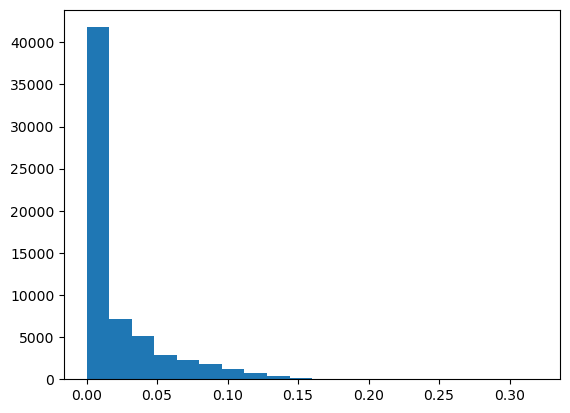

In [8]:
int_flags['distance_site_int'] = int_flags.apply(lambda row: geodesic((row.lat, row.lng), (row.lat_int, row.lng_int)).km, axis=1)
print(f'Max distance: {int_flags.distance_site_int.max()}')
plt.figure()
plt.hist(int_flags.distance_site_int, bins=20)
plt.show()

In [35]:
int_flags = int_flags[int_flags.distance_site_int < 0.015].sort_values(by='distance_site_int')

### Duplication

In [36]:
num_decimals = 4
int_flags['dupe_key'] = int_flags.apply(lambda row: f'{round(row.lat, num_decimals)}_{round(row.lng, num_decimals)}', axis=1)
int_flags.drop_duplicates(subset=['dupe_key'], keep=False)

,lat,lng,intersection,lat_int,lng_int,mtfcc1,mtfcc2,adminCode1,distance,bearing,...,street1Bearing,street2Bearing,adminName2,postalcode,countryCode,street1,street2,adminName1,distance_site_int,dupe_key
55012,40.637337,-74.00047,True,40.637337,-74.000470,S1400,S1400,NY,0,0,...,128,218,Kings,11219,US,52nd St,10th Ave,New York,0.000000,40.6373_-74.0005
32299,40.64721,-74.01531,True,40.647210,-74.015310,S1400,S1400,NY,0,0,...,217,128,Kings,11220,US,3rd Ave,51st St,New York,0.000000,40.6472_-74.0153
62323,40.66606,-73.95863,True,40.666060,-73.958630,S1400,S1400,NY,0,0,...,104,196,Kings,11225,US,Montgomery St,McKeever Pl,New York,0.000000,40.6661_-73.9586
20800,40.632664,-74.03613,True,40.632664,-74.036130,S1400,S1400,NY,0,0,...,197,107,Kings,11209,US,Narrows Ave,76th St,New York,0.000000,40.6327_-74.0361
5892,40.66024,-73.83244,True,40.660240,-73.832440,S1400,S1400,NY,0,0,...,169,79,Queens,11414,US,101st St,159th Ave,New York,0.000000,40.6602_-73.8324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43713,40.600727,-73.75393,True,40.600712,-73.753754,S1400,S1400,NY,0.01,96,...,281,11,Queens,11691,US,New Haven Ave,Beach 20th St,New York,0.014990,40.6007_-73.7539
10239,40.74745,-73.88561,True,40.747440,-73.885787,S1400,S1400,NY,0.01,265,...,82,172,Queens,11372,US,Roosevelt Ave,80th St,New York,0.014990,40.7474_-73.8856
50133,40.761623,-73.93144,True,40.761706,-73.931580,S1400,S1400,NY,0.01,308,...,121,213,Queens,11106,US,34th Ave,24th St,New York,0.014990,40.7616_-73.9314
1863,40.83681,-73.9401,True,40.836945,-73.940102,S1400,S1400,NY,0.02,359,...,352,299,New York,10032,US,St Nicholas Ave,W 163rd St,New York,0.014993,40.8368_-73.9401


In [37]:
num_decimals = 10
int_flags.lat_int = int_flags.lat_int.astype(float)
int_flags.lng_int = int_flags.lng_int.astype(float)
int_flags['dupe_key'] = int_flags.apply(lambda row: f'{round(row.lat_int, num_decimals)}_{round(row.lng_int, num_decimals)}', axis=1)
int_flags.drop_duplicates(subset=['dupe_key'], keep=False)

,lat,lng,intersection,lat_int,lng_int,mtfcc1,mtfcc2,adminCode1,distance,bearing,...,street1Bearing,street2Bearing,adminName2,postalcode,countryCode,street1,street2,adminName1,distance_site_int,dupe_key
55012,40.637337,-74.00047,True,40.637337,-74.000470,S1400,S1400,NY,0,0,...,128,218,Kings,11219,US,52nd St,10th Ave,New York,0.000000,40.637337_-74.00047
32299,40.64721,-74.01531,True,40.647210,-74.015310,S1400,S1400,NY,0,0,...,217,128,Kings,11220,US,3rd Ave,51st St,New York,0.000000,40.64721_-74.01531
62323,40.66606,-73.95863,True,40.666060,-73.958630,S1400,S1400,NY,0,0,...,104,196,Kings,11225,US,Montgomery St,McKeever Pl,New York,0.000000,40.66606_-73.95863
20800,40.632664,-74.03613,True,40.632664,-74.036130,S1400,S1400,NY,0,0,...,197,107,Kings,11209,US,Narrows Ave,76th St,New York,0.000000,40.632664_-74.03613
5892,40.66024,-73.83244,True,40.660240,-73.832440,S1400,S1400,NY,0,0,...,169,79,Queens,11414,US,101st St,159th Ave,New York,0.000000,40.66024_-73.83244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61539,40.756596,-73.73315,True,40.756634,-73.732980,S1400,S1400,NY,0.01,73,...,68,46,Queens,11362,US,61st Ave,60th Ave,New York,0.014963,40.756634_-73.73298
46909,40.703377,-73.86343,True,40.703392,-73.863254,S1400,S1400,NY,0.01,83,...,87,58,Queens,11385,US,Myrtle Ave,Union Tpke,New York,0.014967,40.703392_-73.863254
4876,40.749832,-73.94842,True,40.749875,-73.948588,S1400,S1400,NY,0.01,288,...,104,212,Queens,11101,US,44th Ave,12th St,New York,0.014970,40.749875_-73.948588
27117,40.852615,-73.90351,True,40.852495,-73.903591,S1400,S1400,NY,0.01,207,...,120,32,Bronx,,US,E Burnside Ave,Grand Concourse,New York,0.014975,40.852495_-73.903591


In [48]:
int_flags_deduped = int_flags.drop_duplicates(subset=['dupe_key'], keep=False)
int_flags_deduped.shape

(10463, 21)

# Sample Images

In [38]:
def get_satellite_image(lat, lon, zoom=20, size="640x640", map_type="satellite", api_key=maps_api_key):
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": f"{lat},{lon}",
        "zoom": zoom,
        "size": size,
        "maptype": map_type,
        "key": api_key
    }
    response = requests.get(base_url, params=params)
    image = Image.open(BytesIO(response.content))
    return image

In [39]:
int_flags[int_flags.duplicated(subset=['dupe_key'], keep=False)].sort_values(by='dupe_key').head(30)

,lat,lng,intersection,lat_int,lng_int,mtfcc1,mtfcc2,adminCode1,distance,bearing,...,street1Bearing,street2Bearing,adminName2,postalcode,countryCode,street1,street2,adminName1,distance_site_int,dupe_key
27340,40.504831,-74.241639,True,40.504832,-74.241639,S1400,S1400,NY,0,18,...,165,255,Richmond,10307,US,Yetman Ave,Hylan Blvd,New York,0.000082,40.504832_-74.241639
61877,40.50483,-74.241646,True,40.504832,-74.241639,S1400,S1400,NY,0,69,...,255,165,Richmond,10307,US,Hylan Blvd,Yetman Ave,New York,0.000634,40.504832_-74.241639
44696,40.505527,-74.238175,True,40.505527,-74.238181,S1400,S1400,NY,0,263,...,255,166,Richmond,10307,US,Hylan Blvd,Sprague Ave,New York,0.000486,40.505527_-74.238181
5541,40.505527,-74.23818,True,40.505527,-74.238181,S1400,S1400,NY,0,270,...,255,166,Richmond,10307,US,Hylan Blvd,Sprague Ave,New York,0.000085,40.505527_-74.238181
47982,40.509045,-74.24691,True,40.509045,-74.246903,S1400,S1400,NY,0,89,...,249,145,Richmond,10307,US,Amboy Rd,Main St,New York,0.000593,40.509045_-74.246903
12122,40.509044,-74.246901,True,40.509045,-74.246903,S1400,S1400,NY,0,294,...,248,165,Richmond,10307,US,Amboy Rd,Main St,New York,0.000159,40.509045_-74.246903
10031,40.511947,-74.239701,True,40.511946,-74.239701,S1400,S1400,NY,0,165,...,143,229,Richmond,10307,US,Barnard Ave,Amboy Rd,New York,0.000137,40.511946_-74.239701
5396,40.511948,-74.23971,True,40.511946,-74.239701,S1400,S1400,NY,0,106,...,143,235,Richmond,10307,US,Barnard Ave,Amboy Rd,New York,0.000794,40.511946_-74.239701
1230,40.513875,-74.236669,True,40.513875,-74.236668,S1400,S1400,NY,0,78,...,235,144,Richmond,10307,US,Amboy Rd,Hecker St,New York,0.000112,40.513875_-74.236668
61062,40.513874,-74.23668,True,40.513875,-74.236668,S1400,S1400,NY,0,83,...,235,144,Richmond,10307,US,Amboy Rd,Hecker St,New York,0.001023,40.513875_-74.236668


Stree1 Amboy Rd -- Street2: Station Ave


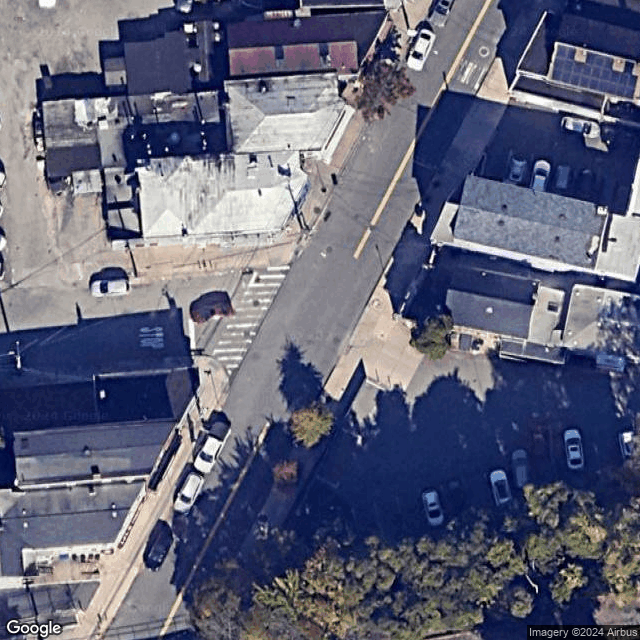

In [46]:
record = int_flags.loc[2435]
print(f'Stree1 {record.street1} -- Street2: {record.street2}')
img = get_satellite_image(record.lat, record.lng)
display(img)

In [52]:
int_flags_deduped.adminName2.value_counts()

adminName2
Queens      4355
Kings       2770
Bronx       1610
Richmond    1082
New York     642
Nassau         4
Name: count, dtype: int64

Blake Ave and Cleveland St -- Kings


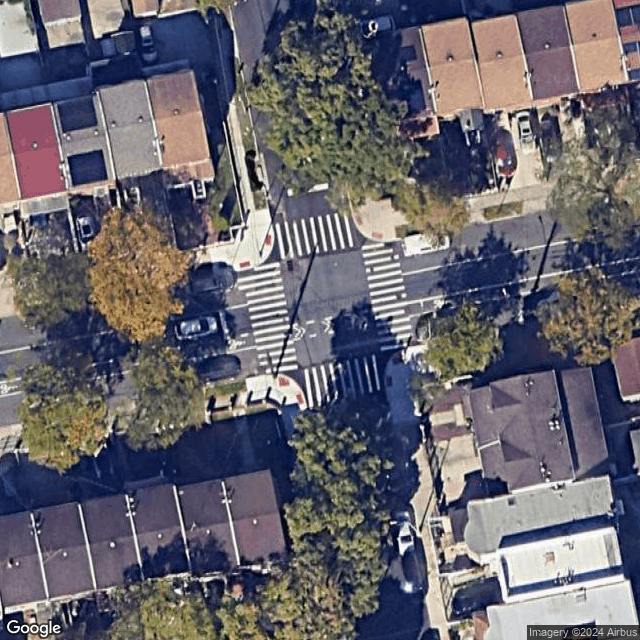

Murdock Ave and 194th St -- Queens


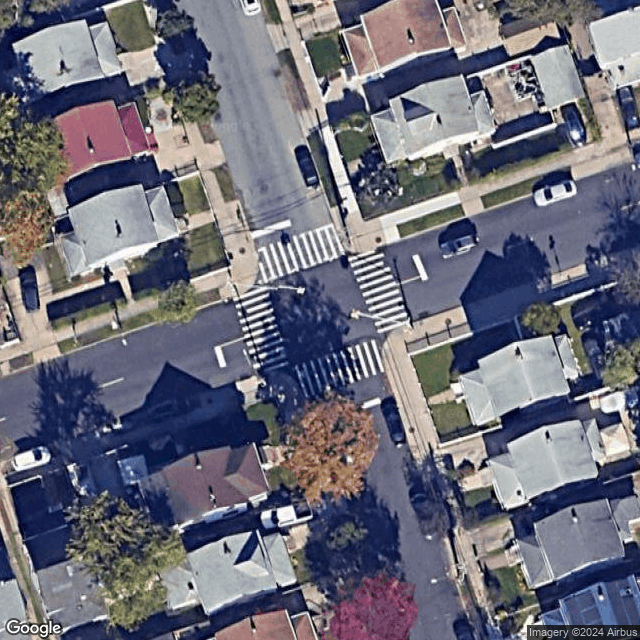

Wortman Ave and Barbey St -- Kings


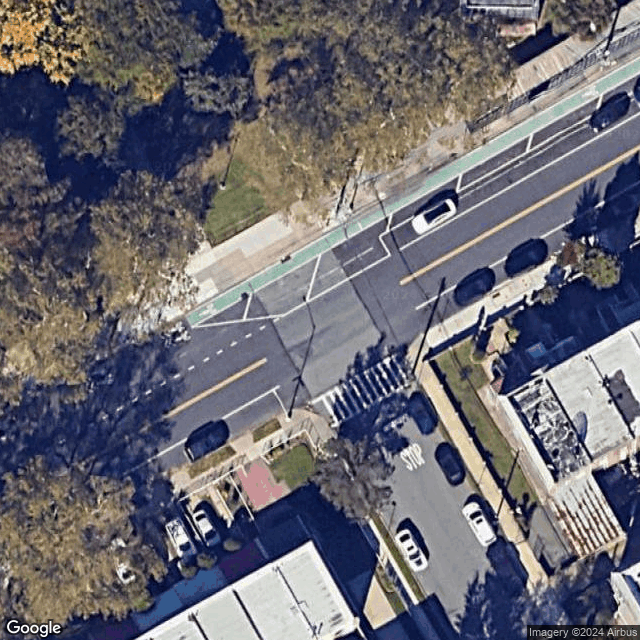

Shore Pkwy and Bay 43rd St -- Kings


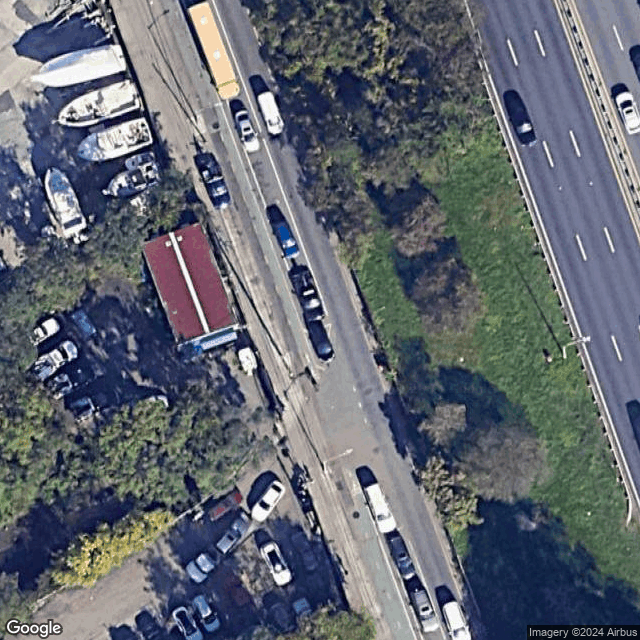

36th St and 23rd Ave -- Queens


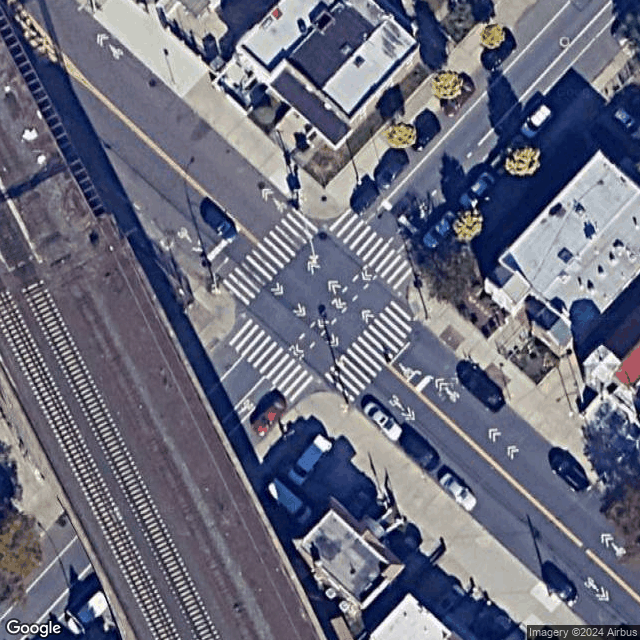

64th St and 2nd Ave -- Kings


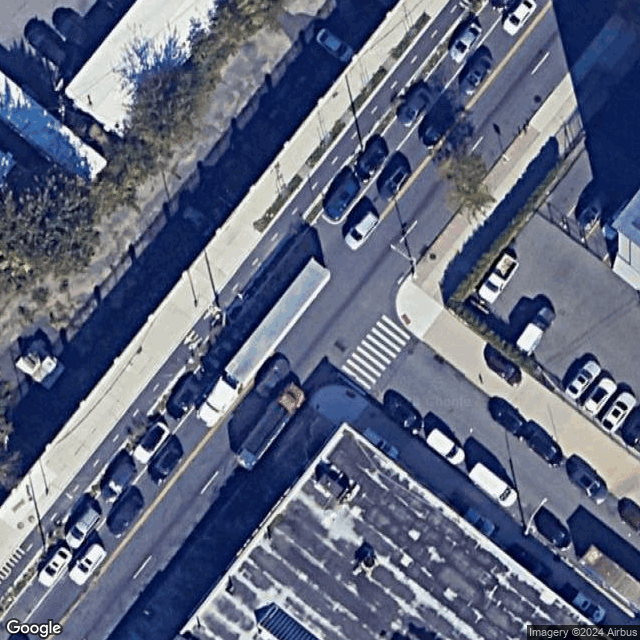

Greenpoint Ave and 40th St -- Queens


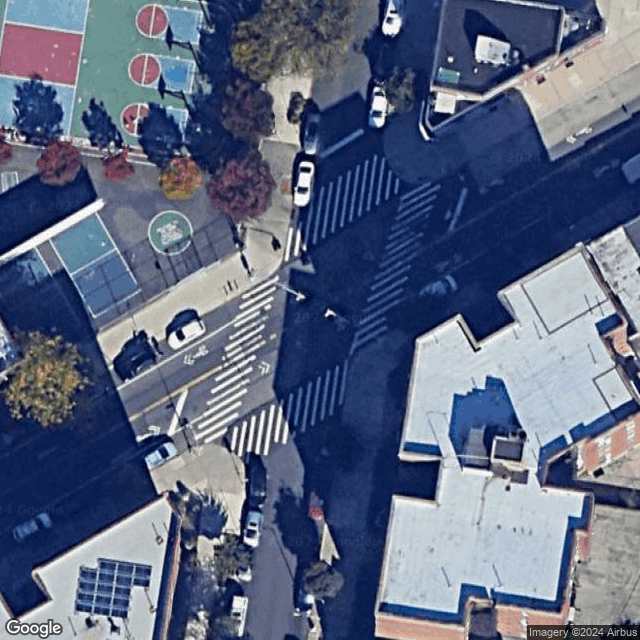

131st Ave and 228th St -- Queens


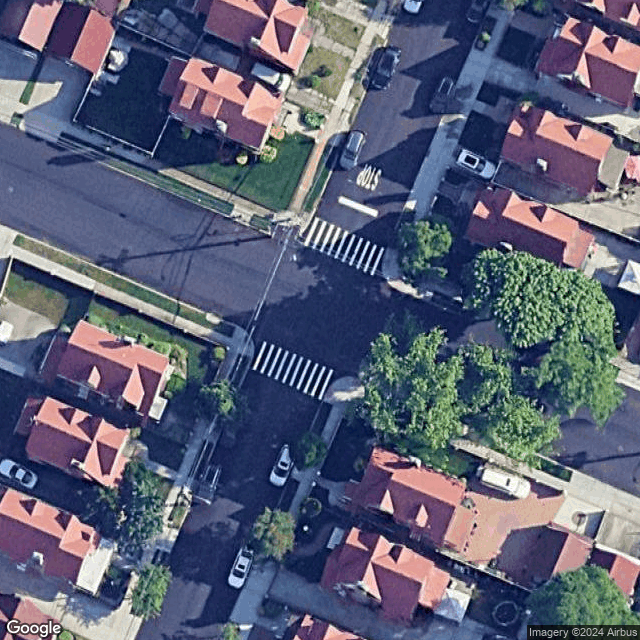

E 83rd St and Madison Ave -- New York


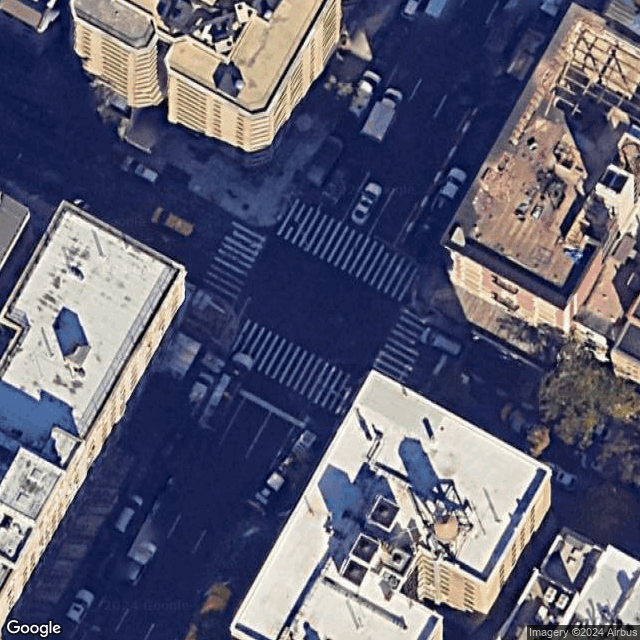

I- 678 and Jamaica Ave -- Queens


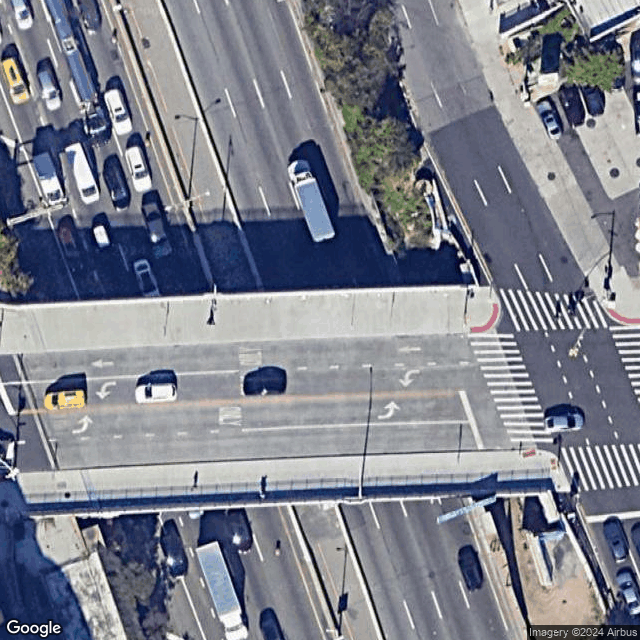

In [56]:
for i in np.random.randint(0, int_flags_deduped.shape[0], 10):
    record = int_flags_deduped.iloc[i]
    print(f'{record.street1} and {record.street2} -- {record.adminName2}')
    img = get_satellite_image(record.lat, record.lng, size="1280x1280")
    # img.save(f'../data/raw/gmaps/{record.street1}_{record.street2}_{record.adminName2}.png')
    display(img)